In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import head_direction as hd
import expipe
import exdir
import os
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import data_processing as dp
from utils import *

In [4]:
# change matplotlib default figsize and fonts
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize') or
        k.endswith('titlesize')
    )
})

In [5]:
# get actions
project_path = dp.project_path()
project = expipe.get_project(project_path)

### Initialise data loader

In [6]:
# remove leading and trailing recording data
t_start = 0
t_stop = None # None => don't remove anything

max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size=0.02
smoothing = 0.05

data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=False, baseline_duration=None,
)

### Load data (tracking and spikes)

In [7]:
# select actions to include
actions = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6']

# load all tracking data (dict)trial x (dict)track_quantities x (array)time
tracking = [(action_id, data_loader.tracking(action_id)) for action_id in actions]
tracking = {action_id:track for action_id, track in tracking}

# load all spikes data (dict)trial x (dict)unit_id x spike_train
spikes = {}
for action_id in tqdm.tqdm(actions):
    spikes[action_id] = {}
    channel_grps = dp.get_channel_groups(data_loader.data_path(action_id))
    for channel_grp in channel_grps:
        # load units and "flatten" channel_grps dimension. - assuming units are unique OR duplicates across channels
        spikes[action_id].update(data_loader.spike_trains(action_id, channel_grp))

100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


### Create rate maps from first and second half of trials

In [8]:
# create ratemaps from first and second half of trial
def partial_ratemap(*args, **kwargs):
    # not a general function - uses global vars etc
    (x,y),t,spike_times = dp.data_scope(*args, **kwargs)
    spatial_map = sp.SpatialMap(x,y,t,spike_times, box_size=box_size, bin_size=bin_size) # global vars
    ratemap = spatial_map.rate_map(smoothing=smoothing, mask_zero_occupancy=True) # global vars
    ratemap = np.rot90(ratemap)
    return ratemap

ratemaps = {}
for action_id in tqdm.tqdm(actions):
    ratemaps[action_id] = {}
    x,y,t,_ = tracking[action_id].values()
    for unit_id in spikes[action_id]:
        spike_times = spikes[action_id][unit_id]
        ratemaps[action_id][unit_id] = [partial_ratemap([x,y], t, spike_times, scope=np.array([0.0, 0.5])), \
                    partial_ratemap([x,y], t, spike_times, scope=np.array([0.5, 1.0]))]

100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


### (Stability) Correlate 50/50 trail-split rate maps

In [8]:
stability = {}
for action_id in actions:
    stability[action_id] = []
    for unit_id in spikes[action_id]:
        stability[action_id].append(nancorrcoef(*ratemaps[action_id][unit_id]))

### Group units into trials

### Plot (violin) and summarise statistics (Mann-U)

011-120321-2 vs 011-120321-3: MannwhitneyuResult(statistic=529.0, pvalue=0.35159759560124937)
011-120321-2 vs 011-120321-4: MannwhitneyuResult(statistic=415.0, pvalue=0.9380217610161472)
011-120321-2 vs 011-120321-5: MannwhitneyuResult(statistic=428.0, pvalue=0.37376089429078274)
011-120321-2 vs 011-120321-6: MannwhitneyuResult(statistic=522.0, pvalue=0.694309797927269)


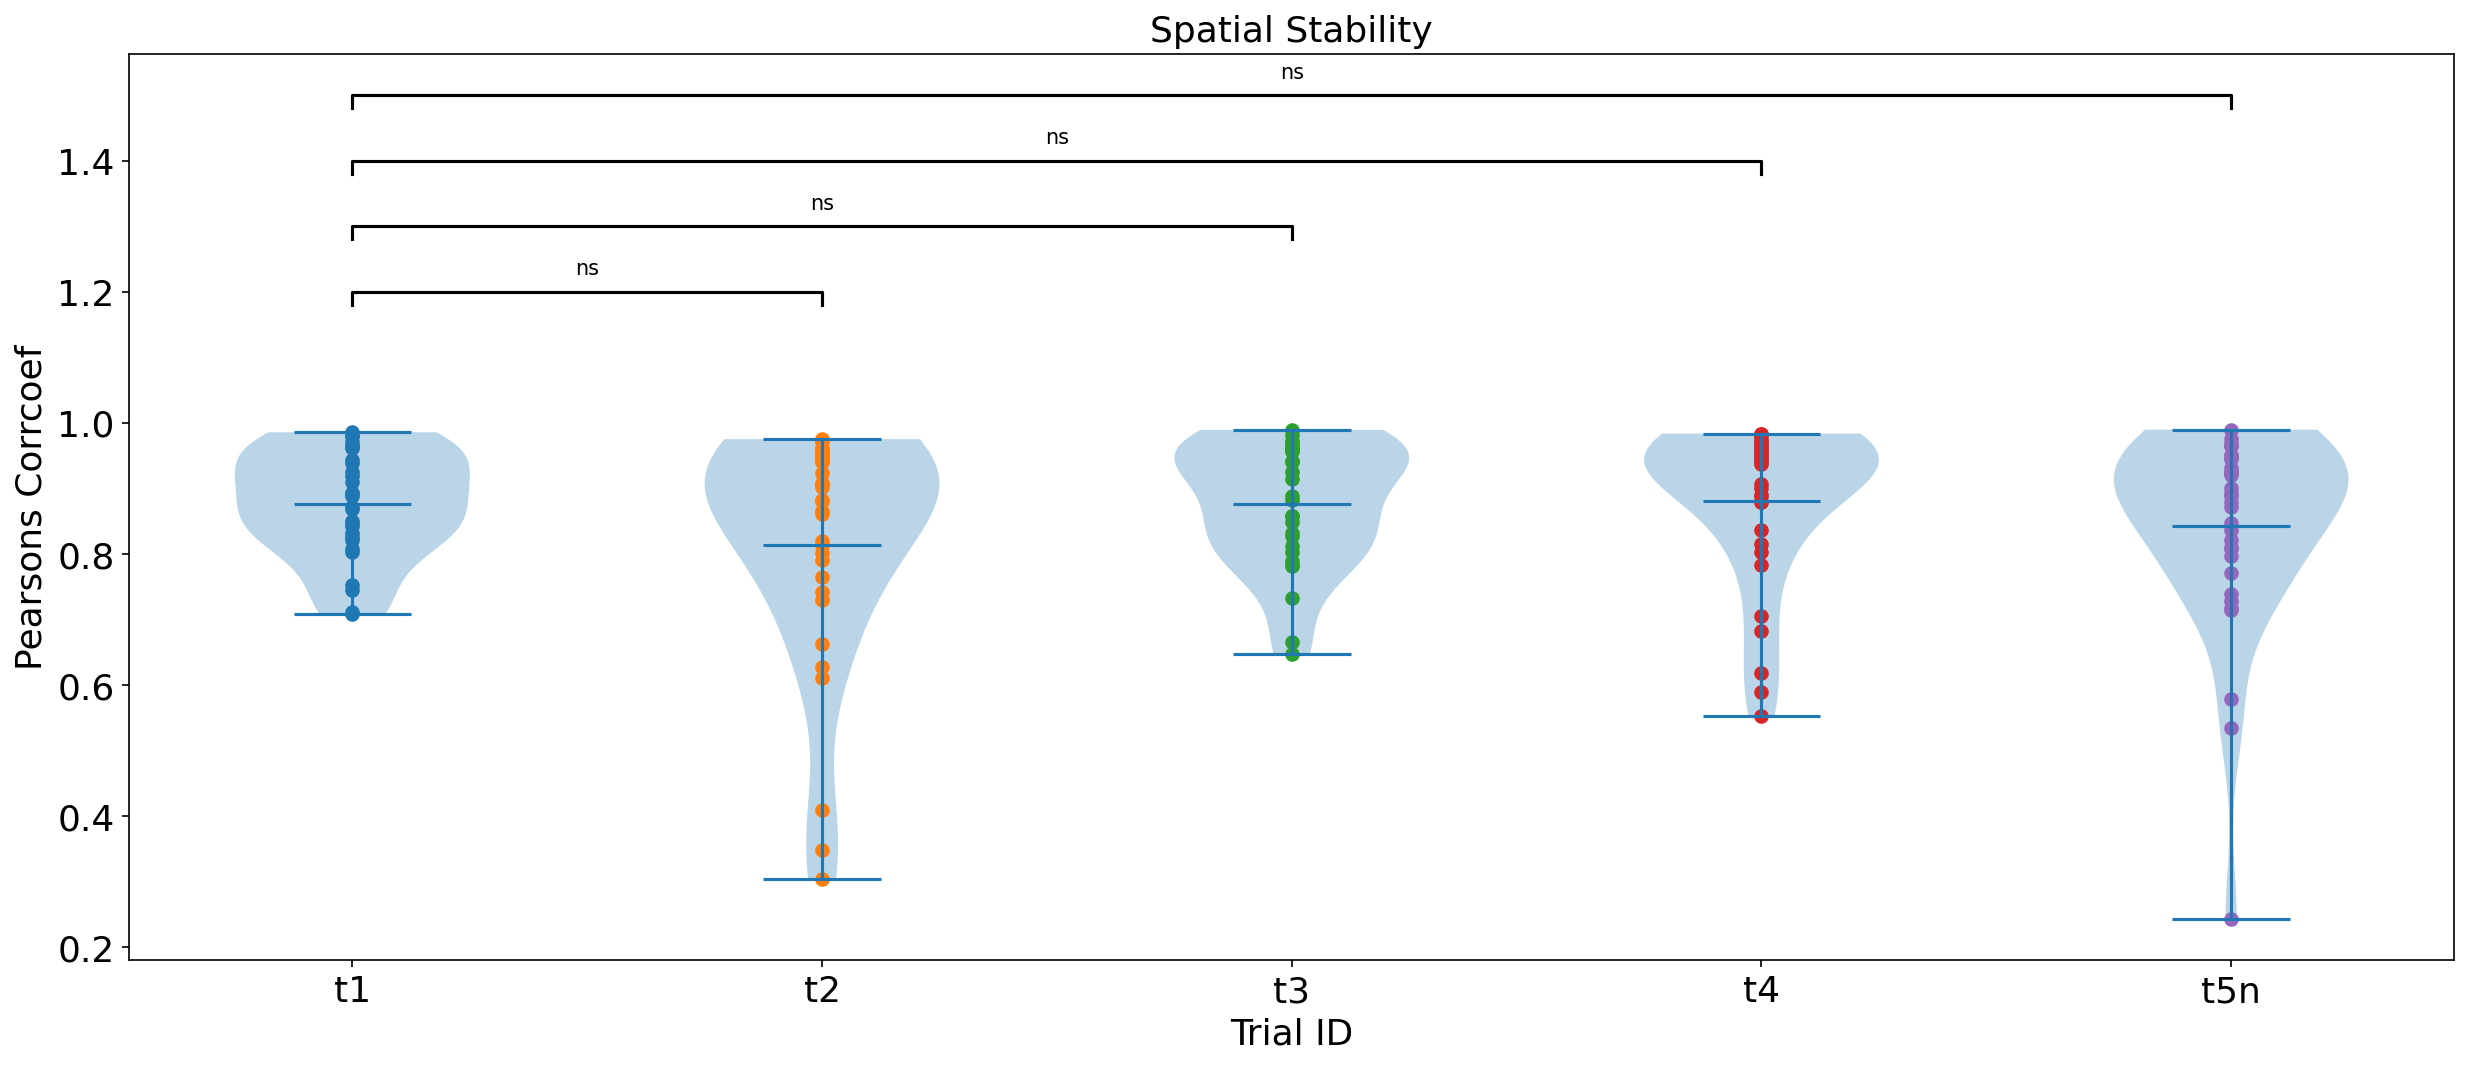

In [9]:
plt.rcParams.update({'figure.dpi': 150, 'legend.frameon': False})
# sns.set_style('white', {'legend.frameon': False})
palette = {'setosa': '#7fc97f', 'versicolor': '#beaed4', 'virginica': '#fdc086'}

fig, ax = plt.subplots(figsize=(20,8))
ax.violinplot(stability.values(), showmeans=True)
#plt.xticks(rotation=45)

# --- plot formatting ---
# add trial labels to x-axes ticks
labels = [trial_id(project.require_action(action_id)) for action_id in stability.keys()]
ticks_locs = np.arange(1, len(labels) + 1)
ax.set_xticks(ticks_locs)
ax.set_xticklabels(labels)

# --- Plot data points in the violin ---
for xtick, correlations in zip(ticks_locs, stability.values()):
    ax.scatter(np.ones(len(correlations))*xtick, correlations)

# set axes and title labels
ax.set_title('Spatial Stability')
ax.set_ylabel('Pearsons Corrcoef')
ax.set_xlabel('Trial ID')

def plot_significance(pvalue, x = [0, 1], y=1.2, h=0.02):
    # significance
    if pvalue < 0.0001:
        significance = "****"
    elif pvalue < 0.001:
        significance = "***"
    elif pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = "ns"

    x1, x2 = x
    plt.plot([x1, x1, x2, x2], [y - h, y, y, y - h], c='k')
    plt.text((x1 + x2) / 2, y + h, significance, ha='center', va='bottom')

    
for i, t_id in enumerate(stability):
    if i == 0:
        baseline = t_id
        continue
        
    mw = scipy.stats.mannwhitneyu(stability[baseline], stability[t_id], alternative='two-sided')
    print(baseline + " vs " + t_id + ":", mw)
    plot_significance(mw.pvalue, [1,i+1], y = 1.1 + (i)*0.1)
    
"""
# check sample similarities using mannwhytney (non-parametric) test
for t_id in range(2,7):
    mw = scipy.stats.mannwhitneyu(trial_correlations[1], trial_correlations[t_id], alternative='two-sided')
    print("T1 vs T" + str(t_id) + ":", mw)
    plot_significance(mw.pvalue, [1,t_id], y = 1.1 + (t_id-2)*0.1)
"""
plt.savefig('./plots/inter-trial-spatial-stability.pdf')